In [260]:
import pandas as pd
import numpy as np
from numpy.linalg import inv, eig, svd
from numpy.random import uniform, multivariate_normal, rand, randn, seed
from itertools import repeat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from jupyterthemes import jtplot

In [261]:
jtplot.style(theme='onedork', context='talk', fscale=1.8, spines=False, 
             gridlines='--', ticks=True, grid=False, figsize=(7, 5))
%matplotlib notebook
pd.options.display.float_format = '{:,.2f}'.format
seed(42)

In [262]:
def format3D(axis, labels=('x', 'y', 'z'), limits=None):
    """3D plot helper function to set labels, pane color, and axis limits"""
    axis.set_xlabel('\n${}$'.format(labels[0]), linespacing=3)
    axis.set_ylabel('\n${}$'.format(labels[1]), linespacing=3)
    axis.set_zlabel('\n${}$'.format(labels[2]), linespacing=3)
    transparent = (1.0, 1.0, 1.0, 0.0)
    axis.w_xaxis.set_pane_color(transparent)
    axis.w_yaxis.set_pane_color(transparent)
    axis.w_zaxis.set_pane_color(transparent)
    if limits:
        axis.set_xlim(limits[0])
        axis.set_ylim(limits[1])
        axis.set_zlim(limits[2])

### Creating a noisy 3D Ellipse

In [263]:
n_points, noise = 100, 0.1
angles = uniform(low=-np.pi, high=np.pi, size=n_points)
x = 2 * np.cos(angles) + noise * randn(n_points)
y = np.sin(angles) + noise * randn(n_points)

theta = np.pi/4 # 45 degree rotation
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                            [np.sin(theta), np.cos(theta)]])

rotated = np.column_stack((x, y)).dot(rotation_matrix)
x, y = rotated[:, 0], rotated[:, 1]

z = .2 * x  + .2 * y + noise * randn(n_points)
data = np.vstack((x, y, z)).T

### Plot the result 

<IPython.core.display.Javascript object>


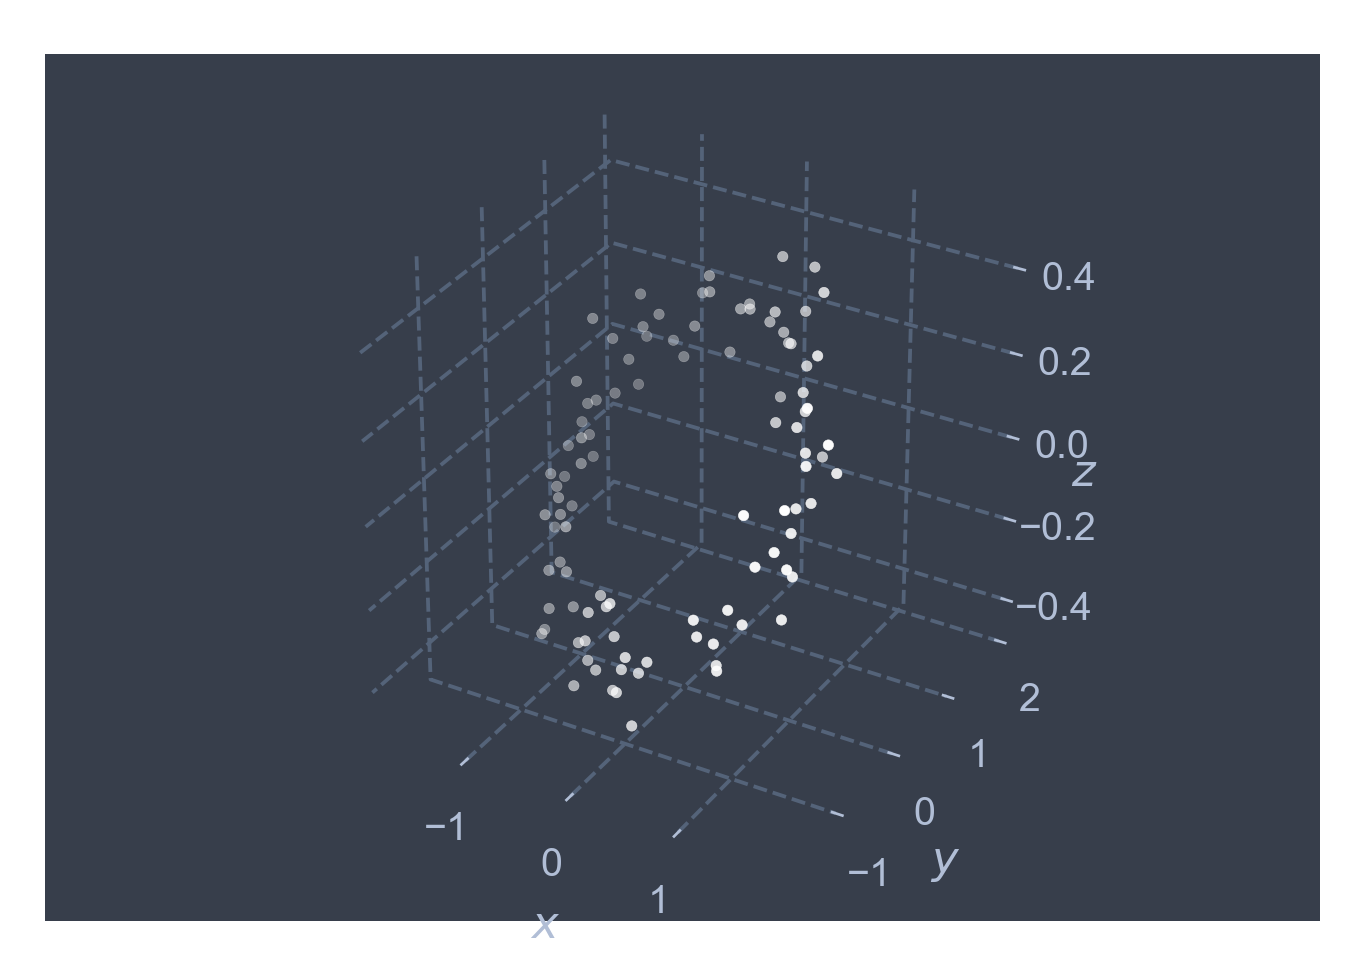

In [264]:
ax = plt.figure().gca(projection='3d')
ax.set_aspect('equal')
ax.scatter(x, y, z, c='white', s=25)
format3D(ax)
plt.tight_layout();

### Principal Components using scikit-learn

In [265]:
pca = PCA()
pca.fit(data)
C = pca.components_.T # columns = principal components
C

array([[ 0.71409739,  0.66929454,  0.20520656],
       [-0.70000234,  0.68597301,  0.1985894 ],
       [ 0.00785136,  0.28545725, -0.95835928]])

In [266]:
C[:, 0]

array([ 0.71409739, -0.70000234,  0.00785136])

In [267]:
explained_variance = pca.explained_variance_
explained_variance

array([ 1.92923132,  0.55811089,  0.00581353])

In [268]:
np.allclose(explained_variance/np.sum(explained_variance), 
            pca.explained_variance_ratio_)

True

### Principal Components from Covariance Matrix

- The covariance matrix is based on: $cov_{x,y}=\frac{\sum_{i=1}^{N}(x_{i}-\bar{x})(y_{i}-\bar{y})}{N-1}$

In [269]:
cov = np.cov(data.T) # each row represents a feature
cov.shape

(3, 3)

#### Eigendecomposition: Eigenvectors & Eigenvalues 

- The Eigenvectors $w_i$ and Eigenvalues $\lambda_i$ for a square matrix $M$ are defined as follows:
$$M w_i = \lambda_i w_i$$

- This implies we can represent the matrix $M$ using Eigenvectors and Eigenvalues, where $W$ is a matrix that contains the Eigenvectors as column vectors, and $L$ is a matrix that contains the $\lambda_i$ as diagonal entries (and 0s otherwise):
$$M=WLW^{-1}$$

In [270]:
eigen_values, eigen_vectors = eig(cov)

#### eigenvectors = principal components 

In [271]:
eigen_vectors

array([[ 0.71409739, -0.66929454, -0.20520656],
       [-0.70000234, -0.68597301, -0.1985894 ],
       [ 0.00785136, -0.28545725,  0.95835928]])

In [272]:
np.allclose(np.abs(C), np.abs(eigen_vectors))

True

#### eigenvalues = explained variance 

In [273]:
eigen_values

array([ 1.92923132,  0.55811089,  0.00581353])

In [274]:
np.allclose(explained_variance, eigen_values)

True

#### Check that Eigendecomposition works

In [275]:
ev = np.zeros((3, 3))
np.fill_diagonal(ev, eigen_values)
ev # diagonal matrix

array([[ 1.92923132,  0.        ,  0.        ],
       [ 0.        ,  0.55811089,  0.        ],
       [ 0.        ,  0.        ,  0.00581353]])

In [276]:
decomposition = eigen_vectors.dot(ev).dot(inv(eigen_vectors))
np.allclose(cov, decomposition)

True

### Preferred: Singular Value Decomposition

#### Requires centering your data! 

In [277]:
n_features = data.shape[1]
data_ = data - data.mean(axis=0)

In [278]:
cov_manual = data_.T.dot(data_)/(len(data)-1)
np.allclose(cov_manual, cov)

True

In [279]:
U, s, Vt = svd(data_)
U.shape, s.shape, Vt.shape

((100, 100), (3,), (3, 3))

In [280]:
# Convert s from vector to diagonal matrix
S = np.zeros_like(data_)
S[:n_features, :n_features] = np.diag(s)
S.shape

(100, 3)

#### Show that the result indeed decomposes the original data

In [281]:
np.allclose(data_, U.dot(S).dot(Vt))

True

#### Confirm that $V^T$ contains the principal components 

In [282]:
np.allclose(np.abs(C), np.abs(Vt.T))

True

### Visualize 2D Projection 

In [283]:
pca = PCA(n_components=2)
data_2D = pca.fit_transform(data)

min_, max_ = data[:, :2].min(), data[:, :2].max()
xs, ys = np.meshgrid(np.linspace(min_,max_, n_points), 
                     np.linspace(min_,max_, n_points))

normal_vector = np.cross(pca.components_[0], pca.components_[1])
d = -pca.mean_.dot(normal_vector)
zs = (-normal_vector[0] * xs - normal_vector[1] * ys - d) * 1 / normal_vector[2]

In [255]:
C = pca.components_.T.copy()
proj_matrix = C.dot(inv(C.T.dot(C))).dot(C.T)
C[:,0] *= 2

<IPython.core.display.Javascript object>


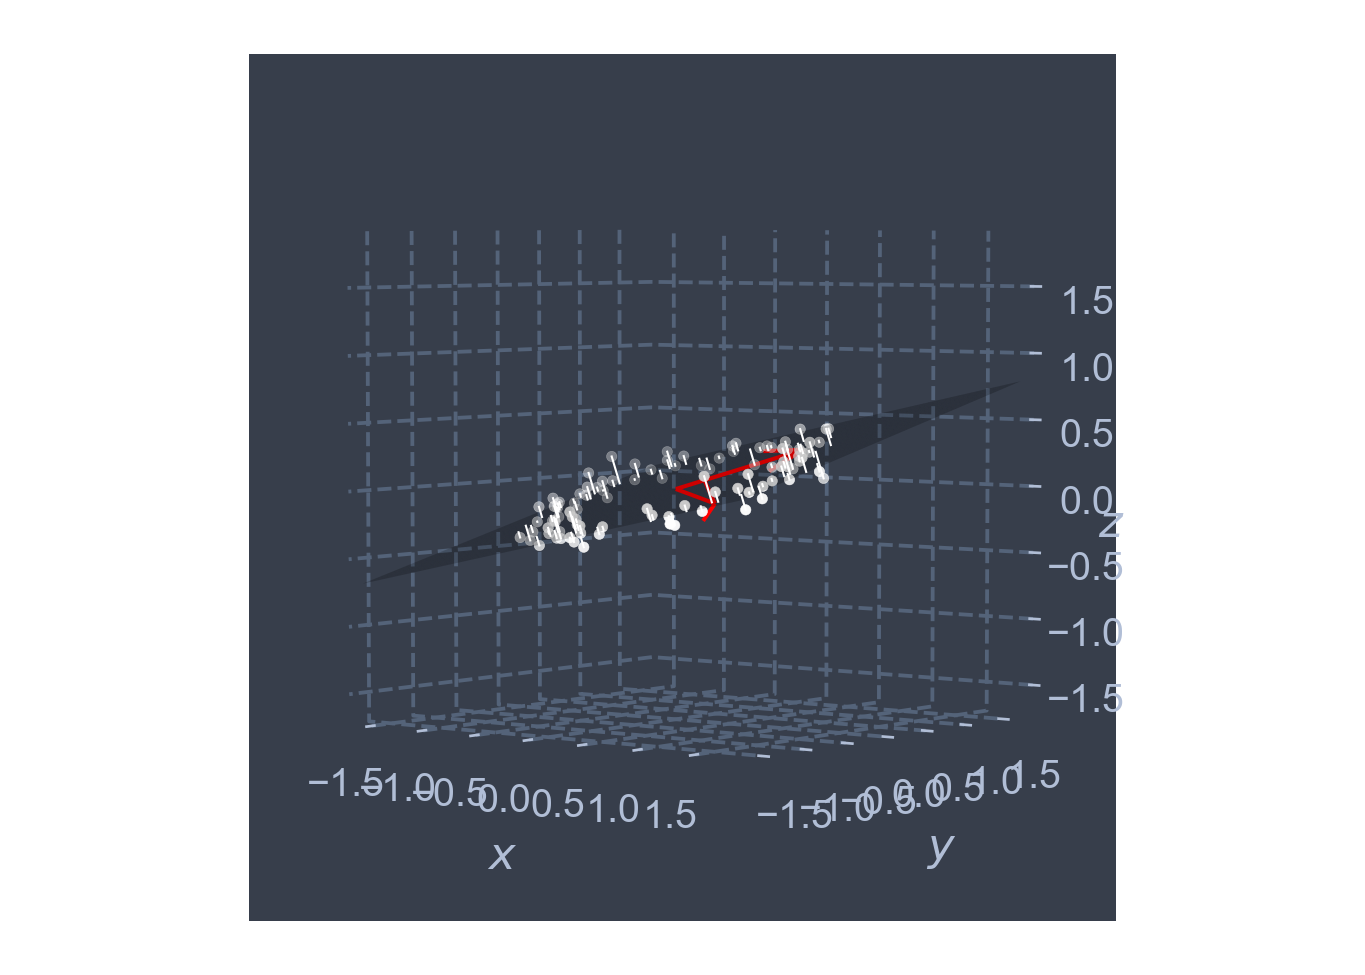

In [256]:
ax = plt.figure().gca(projection='3d')
ax.set_aspect('equal')

ax.plot_surface(xs, ys, zs, alpha=0.2, color='black',
                linewidth=1, antialiased=True)
ax.scatter(x, y, z, c='white', s=25)

for i in range(n_points):
    ax.plot(*zip(proj_matrix.dot(data[i]), data[i]), 
            color='white', lw=1)

origin = np.zeros((2, 3))
X, Y, Z, U, V, W = zip(*np.hstack((origin, C.T)))
ax.quiver(X, Y, Z, U, V, W, color='red')

format3D(ax, limits=list(repeat((min_, max_), 3)))
plt.tight_layout()

### 2D Representation

<IPython.core.display.Javascript object>


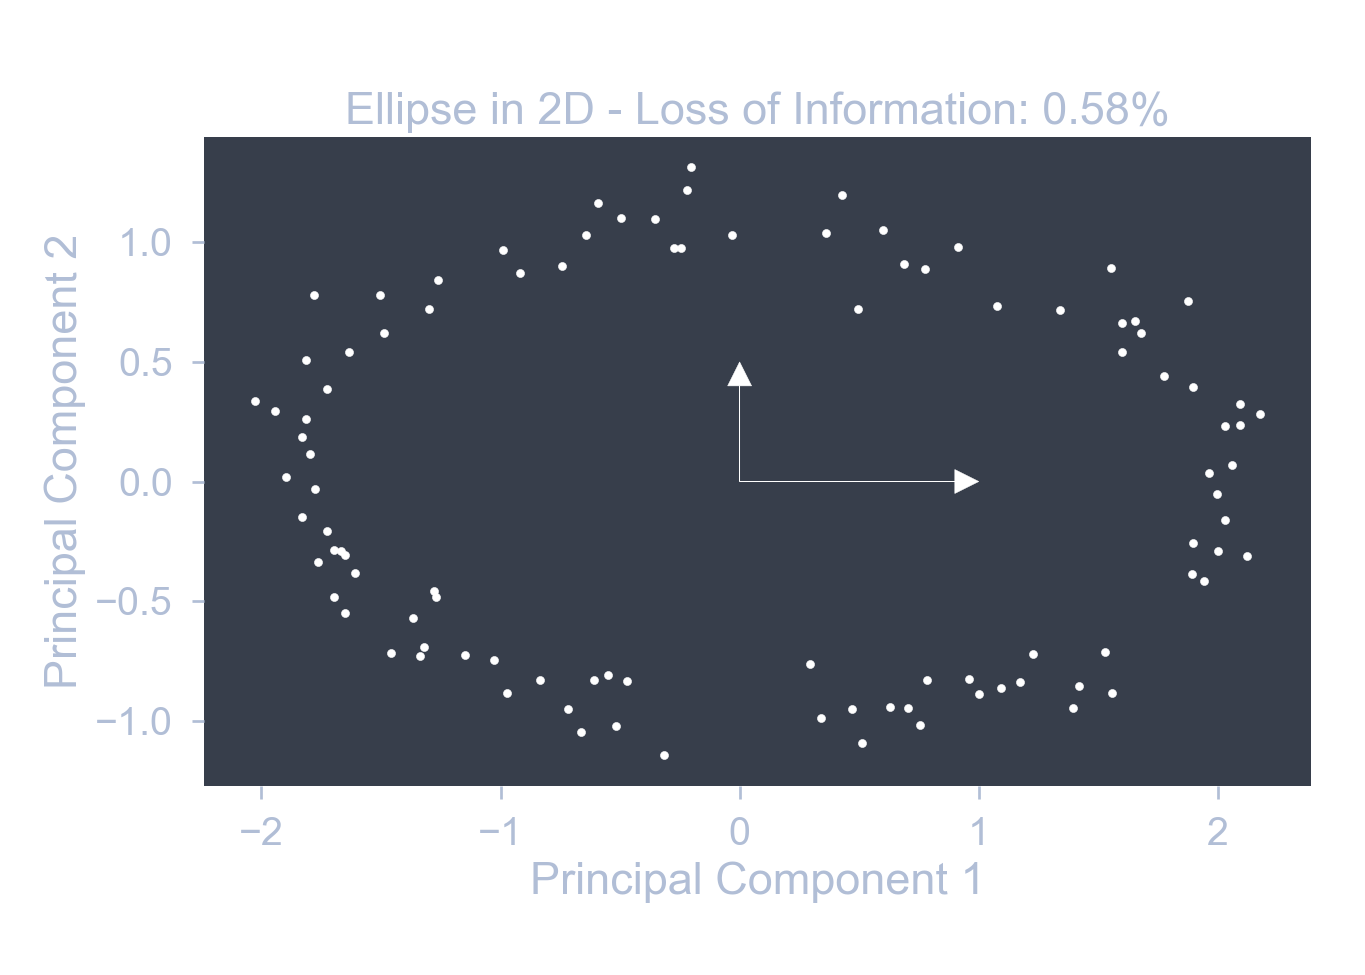

In [257]:
data_3D_inv = pca.inverse_transform(data_2D)
avg_error = np.mean(np.sum(np.square(data_3D_inv-data), axis=1))
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', 
     xlabel='Principal Component 1', 
     ylabel='Principal Component 2', 
     title='Ellipse in 2D - Loss of Information: {:.2%}'.format(avg_error))

ax.scatter(data_2D[:, 0], data_2D[:, 1], color='white', s=15)
ax.arrow(0, 0, 0, .5, head_width=0.1, length_includes_head=True, 
         head_length=0.1, fc='w', ec='w')
ax.arrow(0, 0, 1, 0, head_width=0.1, length_includes_head=True, 
         head_length=0.1, fc='w', ec='w')
fig.tight_layout()

### How many Components to represent 64 dimensions?

In [258]:
n_classes = 10
digits = load_digits(n_class=n_classes)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_samples, n_features

(1797, 64)

#### Evaluate the cumulative explained variance 

<IPython.core.display.Javascript object>


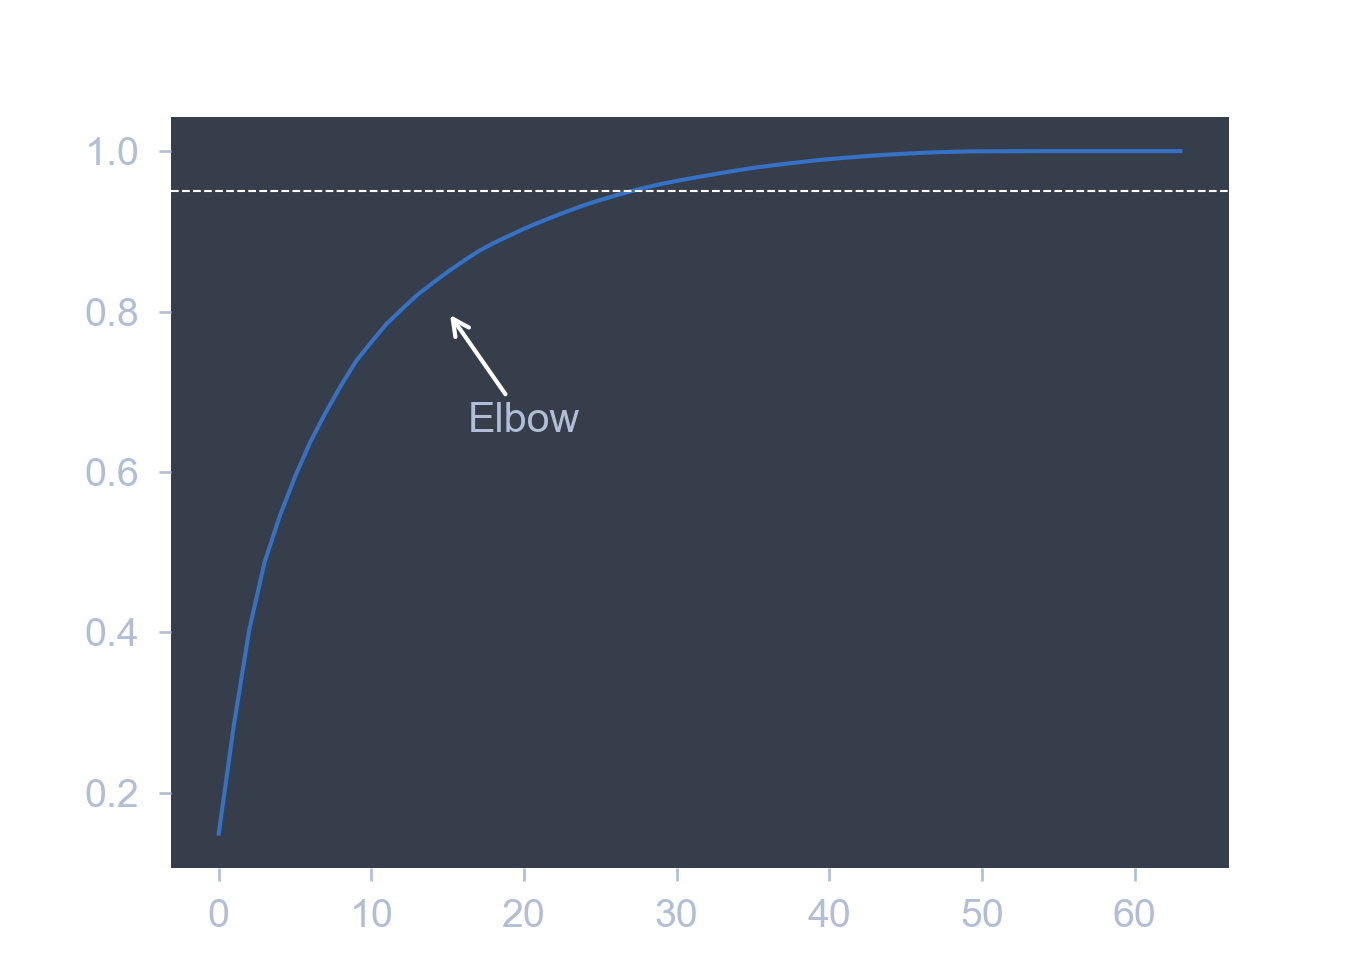

In [259]:
pca = PCA(n_components=64).fit(X)
plt.figure()
pd.Series(pca.explained_variance_ratio_).cumsum().plot()
plt.annotate('Elbow', xy=(15, .8), xycoords='data', xytext=(20, .65),
    textcoords='data', horizontalalignment='center',
    arrowprops=dict(color='w', lw=2, arrowstyle="->")
)
plt.axhline(.95, c='white', lw=1, ls='--');

### Automate generation of Components

In [212]:
pca = PCA(n_components=.95).fit(X)
pca.components_.shape

(29, 64)

## Principal Components from Covariance Matrix

### Get Grocery Data

In [213]:
data = np.log(pd.read_csv('wholesale_customers_data.csv').drop(['Channel', 'Region'], axis=1))
features = data.columns.tolist()
n = len(features)
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.00,440.00,440.00,440.00,440.00,440.00
mean,8.73,8.12,8.44,7.30,6.79,6.67
std,1.48,1.08,1.12,1.28,1.72,1.31
min,1.10,4.01,1.10,3.22,1.10,1.10
25%,8.05,7.33,7.67,6.61,5.55,6.01
50%,9.05,8.20,8.47,7.33,6.71,6.87
75%,9.74,8.88,9.27,8.18,8.27,7.51
max,11.63,11.21,11.44,11.02,10.62,10.78


### Obtain Principal Components

In [214]:
pca = PCA(n_components=n)
data_transformed = pca.fit_transform(data)
# data_3D_inv = pca.inverse_transform(data_2D)
explained = pca.explained_variance_ratio_
pd.Series(explained).cumsum()

0   0.44
1   0.72
2   0.84
3   0.93
4   0.98
5   1.00
dtype: float64

In [215]:
data.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.00,-0.02,-0.13,0.38,-0.16,0.26
Milk,-0.02,1.00,0.76,-0.06,0.68,0.34
Grocery,-0.13,0.76,1.00,-0.16,0.80,0.24
Frozen,0.38,-0.06,-0.16,1.00,-0.21,0.25
Detergents_Paper,-0.16,0.68,0.80,-0.21,1.00,0.17
Delicatessen,0.26,0.34,0.24,0.25,0.17,1.00


In [216]:
pd.DataFrame(data_transformed, columns=data.columns).corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.00,0.00,-0.00,0.00,-0.00,-0.00
Milk,0.00,1.00,0.00,0.00,-0.00,-0.00
Grocery,-0.00,0.00,1.00,-0.00,0.00,0.00
Frozen,0.00,0.00,-0.00,1.00,0.00,0.00
Detergents_Paper,-0.00,-0.00,0.00,0.00,1.00,-0.00
Delicatessen,-0.00,-0.00,0.00,0.00,-0.00,1.00


### Centered Data

In [217]:
data_centered = data - data.mean()
U, s, Vt = np.linalg.svd(data_centered)
S = np.zeros_like(data_centered)
S[:n, :n] = np.diag(s)
np.allclose(data_centered, U.dot(S).dot(Vt))
np.allclose(np.abs(pca.components_), np.abs(Vt))

True

In [218]:
S = np.zeros_like(data_centered)
S[:n, :n] = np.diag(s)

In [219]:
np.allclose(data_centered, U.dot(S).dot(Vt))

True

In [220]:
Vt

array([[-0.17371704,  0.394463  ,  0.45436364, -0.17219603,  0.74551495,
         0.1494356 ],
       [ 0.68513571,  0.16239926,  0.06937908,  0.487691  ,  0.04191162,
         0.50970874],
       [ 0.67351166, -0.03306794,  0.03218274, -0.28481122,  0.21824404,
        -0.64459672],
       [-0.21432619,  0.0185577 ,  0.06448674,  0.80608348,  0.19005006,
        -0.51348977],
       [ 0.00082162, -0.72228834, -0.34799325,  0.03624337,  0.56366476,
         0.19536639],
       [ 0.02927638, -0.54303508,  0.81390826,  0.0174477 , -0.20244363,
         0.02283197]])

In [221]:
pca.components_

array([[ 0.17371704, -0.394463  , -0.45436364,  0.17219603, -0.74551495,
        -0.1494356 ],
       [-0.68513571, -0.16239926, -0.06937908, -0.487691  , -0.04191162,
        -0.50970874],
       [-0.67351166,  0.03306794, -0.03218274,  0.28481122, -0.21824404,
         0.64459672],
       [-0.21432619,  0.0185577 ,  0.06448674,  0.80608348,  0.19005006,
        -0.51348977],
       [-0.00082162,  0.72228834,  0.34799325, -0.03624337, -0.56366476,
        -0.19536639],
       [-0.02927638,  0.54303508, -0.81390826, -0.0174477 ,  0.20244363,
        -0.02283197]])

In [222]:
np.allclose(np.abs(pca.components_), np.abs(Vt))

True

In [223]:
W2 = Vt.T
X2D = data_centered.dot(W2)

### PCA by Covariance Matrix

In [224]:
cov = data_centered.cov()
e, v = np.linalg.eig(cov)

In [225]:
eigen_values = pd.Series(e)

In [226]:
components = pd.DataFrame(pca.components_)
components

,0,1,2,3,4,5
0,0.17,-0.39,-0.45,0.17,-0.75,-0.15
1,-0.69,-0.16,-0.07,-0.49,-0.04,-0.51
2,-0.67,0.03,-0.03,0.28,-0.22,0.64
3,-0.21,0.02,0.06,0.81,0.19,-0.51
4,-0.00,0.72,0.35,-0.04,-0.56,-0.20
5,-0.03,0.54,-0.81,-0.02,0.20,-0.02


In [227]:
eigen_vectors = pd.DataFrame(v.T).loc[eigen_values.sort_values(ascending=False).index].reset_index(drop=True)
eigen_vectors

,0,1,2,3,4,5
0,0.17,-0.39,-0.45,0.17,-0.75,-0.15
1,-0.69,-0.16,-0.07,-0.49,-0.04,-0.51
2,-0.67,0.03,-0.03,0.28,-0.22,0.64
3,0.21,-0.02,-0.06,-0.81,-0.19,0.51
4,-0.00,0.72,0.35,-0.04,-0.56,-0.20
5,0.03,-0.54,0.81,0.02,-0.20,0.02


In [228]:
np.allclose(components.abs(), eigen_vectors.abs())

True

In [229]:
np.allclose(np.abs(v.T[np.argsort(e)[::-1]]), np.abs(pca.components_))

True

### How many Components to represent 64 dimensions?

In [230]:
Slide Type


SyntaxError: invalid syntax (<ipython-input-230-40f54d8961e8>, line 1)